# **AI4Industry** - Introduction au Reservoir Computing et à ReservoirPy

In [ ]:
# Installation de la bibliothèque
%pip install reservoirpy==0.3.*

Note: you may need to restart the kernel to use updated packages.


## Un exemple simple: Mackey-Glass

Les équations de Mackey-Glass décrivent un système chaotique.
https://en.wikipedia.org/wiki/Mackey%E2%80%93Glass_equations

Le code ci-dessous reprend ce qui a été présenté au tableau.

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge

rpy.verbosity(0)
# Rendre tout déterministe
rpy.set_seed(2341)

#### Création de la série temporelle Mackey-Glass

In [3]:
from reservoirpy.datasets import mackey_glass

timeseries = mackey_glass(n_timesteps=2_000)
timeseries.shape

(2000, 1)

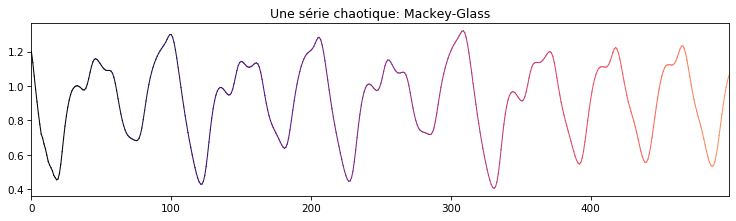

In [4]:
# Affichage
X = timeseries
timesteps = 500
plt.figure(figsize=(12, 3))
for i in range(timesteps-1):
    plt.plot([i, i+1], X[i:i+2, 0], color=plt.cm.magma(200*i//timesteps), lw=1.0)
plt.title("Une série chaotique: Mackey-Glass")
plt.show()

#### Prétraitement des données

On divise la série temporelle en entrées et sorties (X/Y), et en données d'entraînement et d'évaluation (train/test)

In [5]:
from reservoirpy.datasets import to_forecasting

# Ramener tout entre -1.0 et 1.0:
X = (X - X.min()) / (X.max() - X.min())
X = 2*X-1

# Prédiction à 10 pas de temps, 20% des données servent à l'évaluation
dataset = to_forecasting(X, forecast=10, test_size=0.2)
x_train, x_test, y_train, y_test = dataset

In [6]:
print(
    x_train.shape,
    x_test.shape,
    y_train.shape,
    y_test.shape,
)

(1590, 1) (400, 1) (1590, 1) (400, 1)


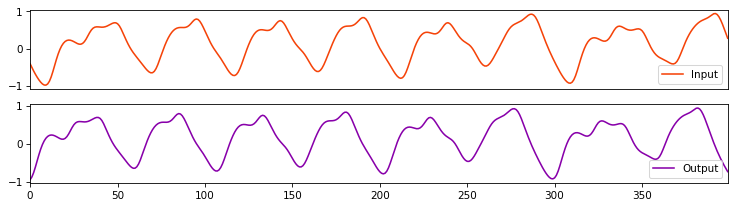

In [7]:
plt.figure(figsize=(12,3))
plt.subplot(2,1,1)
plt.plot(x_test, label="Input")
plt.legend()
plt.xticks([])
plt.subplot(2,1,2)
plt.plot(y_test, label="Output", color="#8800AA")
plt.legend()
plt.show()

#### Création du modèle

In [8]:
from reservoirpy.nodes import ESN

In [9]:
# Création en un seul noeud

model = ESN(
    units=100, # neurones dans le réservoir
    lr=0.3, # taux de fuite
    sr=1.25, # rayon spectral de la matrice de poids
    ridge=1e-8) # Paramètre de régularisation

In [10]:
# Un réservoir connecté à la couche de sortie

reservoir = Reservoir(
    units=100, # nombre de neurones dans le réservoir
    lr=0.3, # taux de fuite
    sr=1.25, # rayon spectral de la matrice de poids
    input_scaling=1.0, # facteur multiplicatif des valeurs d'entrée
)
readout = Ridge(ridge=1e-8) # Couche de régularisation
model = reservoir >> readout # Connection des nœuds

#### Entraînement et évaluation

In [11]:
model.fit(x_train, y_train) # Phase d'apprentissage
y_pred = model.run(x_test) # Phase de prédiction

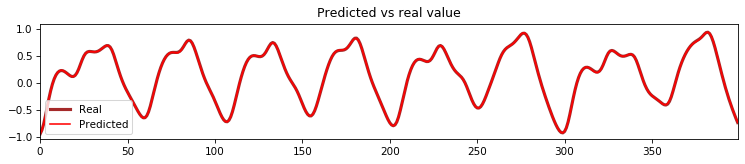

In [12]:
plt.figure(figsize=(12,2))
plt.plot(1)
plt.plot(y_test, label="Real", linewidth=3, color="brown")
plt.plot(y_pred, label="Predicted", color="red")
plt.title("Predicted vs real value")
plt.legend()
plt.show()

### Quid d'une prédiction à $t+50$ ?

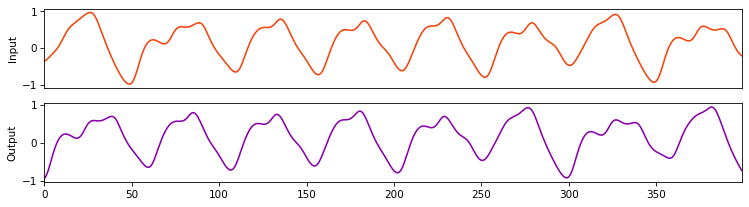

In [13]:
dataset = to_forecasting(X, forecast=50, test_size=0.2)  # prédiction à t+50
x_train, x_test, y_train, y_test = dataset

plt.figure(figsize=(12,3))
plt.subplot(2,1,1)
plt.plot(x_test)
plt.ylabel("Input")
plt.xticks([])
plt.subplot(2,1,2)
plt.plot(y_test, color="#8800AA")
plt.ylabel("Output")
plt.show()

In [14]:
# Création du modèle

reservoir = Reservoir(units=100, lr=0.3, sr=1.25, input_scaling=1.0)
readout = Ridge(ridge=1e-8) 
model = reservoir >> readout

# Entraînement
model.fit(x_train, y_train)
# Évaluation
y_pred = model.run(x_test)

In [15]:
def plot_figure(y_test, y_pred):
    plt.figure(figsize=(12,2))
    plt.plot(1)
    plt.plot(y_test, label="Real", linewidth=3, color="brown")
    plt.plot(y_pred, label="Predicted", color="red")
    plt.title("Predicted vs real value")
    plt.legend()
    plt.show()

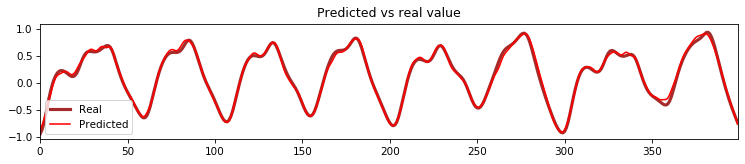

In [16]:
plot_figure(y_test, y_pred)

### Résumé

In [17]:
# On peut changer la seed génératrice d'aléatoire pour changer le poids initiaux des réservoirs 
rpy.set_seed(0)

# Note importante :
# Lorsque vous utilisez le nœud/modèle ESN et que vous avez plusieurs séquences d'entrée,
# la parallélisation CPU sera effectuée en utilisant un cœur par séquence.
# (Ici, nous n'avons qu'une seule séquence, donc le comportement sera le même 
# que si vous définissiez vous-même "model = reservoir >> readout").
# Si vous souhaitez désactiver la parallélisation et n'utiliser qu'un seul cœur CPU,
# vous devez ajouter "workers=1" lors de l'initialisation du modèle ESN 
model = ESN( 
    units=100, # neurones dans le réservoir
    lr=0.3, # taux de fuite
    sr=1.25, # rayon spectral de la matrice de poids
    ridge=1e-8, # paramètre de régularisation
    # workers=1, # utiliser un seul coeur CPU = pour désactiver la parallelisation CPU
    # workers=-1, # par défaut : la parallelisation est activée sur tous les coeurs CPU
)


# Ajustement du modèle
model.fit(x_train, y_train)

# Test du modèle
y_pred = model.run(x_test)


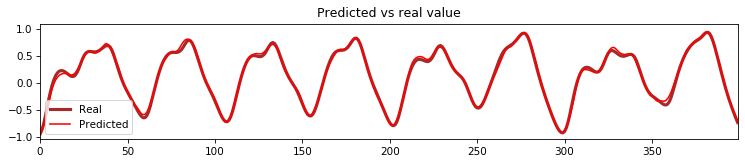

In [18]:
plot_figure(y_test, y_pred)

### Écoutons l'activité du réservoir...

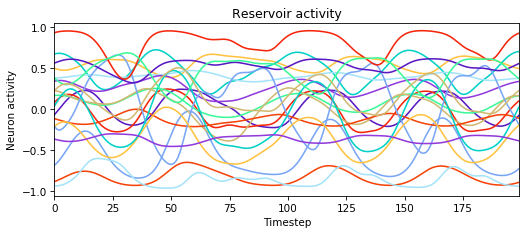

In [19]:
activity = reservoir.run(x_test)

plt.figure(figsize=(8, 3))
plt.plot(activity[:200, :20]) # 200 pas de temps, 20 neurones visualisés
plt.title("Reservoir activity")
plt.xlabel("Timestep")
plt.ylabel("Neuron activity")
plt.show()

In [20]:
# À vous de jouer !
# Définissez et entrainez ci-dessous un modèle de réservoir+readout ou d'ESN en changeant les paramètres précédents

# ...

In [21]:
# Observez les changements sur les valeurs prédites

# ...

In [22]:
# Observez les changements sur l'activité des neurones

# ...

## Une application à de la classification: **EyesOpenShut**

https://www.timeseriesclassification.com/description.php?Dataset=EyesOpenShut

In [23]:
%pip install aeon

Note: you may need to restart the kernel to use updated packages.


In [24]:
from reservoirpy.datasets import from_aeon_classification
from aeon.datasets import load_classification

X_aeon, y = load_classification("EyesOpenShut")

X = from_aeon_classification(X_aeon)

# Pré-traitement: on ramène les valeurs entre -1.0 et 1.0
X = np.apply_along_axis(lambda x: 2*(x - np.min(x)) / (np.max(x) - np.min(x)) - 1, 1, X)
# On convertit les chaînes de caractères en valeurs flottantes
y = y.astype(float)

In [25]:
# Affichage de y
print(y)

[0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


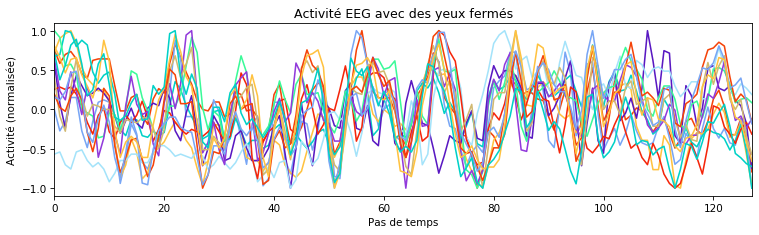

In [26]:
# Affichage de X
OBSERVATION = 0

plt.figure(figsize=(12, 3))
plt.plot(X[OBSERVATION])
plt.xlabel("Pas de temps")
plt.ylabel("Activité (normalisée)")
plt.title(f"Activité EEG avec des yeux {'ouverts' if y[OBSERVATION]==1.0 else 'fermés'}")
plt.show()

In [27]:
# Y doit aussi être une série temporelle ! Pas une unique valeur pour chaque observation
Y = np.repeat(y.reshape(-1, 1, 1), X.shape[1], axis=1)
print(X.shape, Y.shape)

(98, 128, 14) (98, 128, 1)


In [28]:
model = ESN(units=400, lr=0.7, sr=0.95, ridge=1e-4)

model.fit(X[:50], Y[:50])

Y_pred = model.run(X[50:])
Y_pred = np.array(Y_pred)

# On ramène les prédictions d'une série temporelle à une unique variable
y_pred = np.mean(Y_pred, axis=(1, 2))
# y_pred = Y_pred[:, -1, 0]
# On obtient une valeur pour chaque observation, un flottant. On ramène cette valeur à une classe (0.0 ou 1.0)
y_pred_class = (y_pred > 0.5).astype(float)

              precision    recall  f1-score   support

         0.0       0.56      0.74      0.63        27
         1.0       0.42      0.24      0.30        21

    accuracy                           0.52        48
   macro avg       0.49      0.49      0.47        48
weighted avg       0.49      0.52      0.49        48



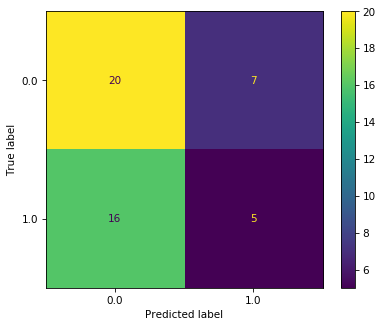

In [29]:
# Affichage des résultats
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_true = y[50:]

print(classification_report(y_true=y_true, y_pred=y_pred_class))

_ = ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred_class)